In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import time
import math
import requests, zipfile, io
from geetools import cloud_mask
from IPython.display import Image
import rasterio
from rasterio.plot import show

#Importing Osgeo Libraries
from osgeo import gdal_array
from osgeo import ogr




#importing Earth Engine packages
import ee #install in the console with "pip install earthengine-api --upgrade"
ee.Authenticate()  #every person needs an Earth Engine account to do this part
ee.Initialize()


ModuleNotFoundError: No module named 'numpy'

In [ ]:
#defining image
startDate = '2021-01-01'
endDate = '2021-12-23'
landsat = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")
# filter date
landsat = landsat.filterDate(startDate, endDate) 
#applying cloud masking
landsat_masked=landsat.map( cloud_mask.landsatSR(['cloud']) )
#selecting bands
landsat_masked=landsat_masked.select(["B2","B3","B4"])
landsat = landsat.select(["B2","B3","B4"])

In [ ]:
def image_download(image,point,image_res,n_pixels,folder_name, image_name, storage="local"):
    
    """
    Function to download satellite images from a ee.imageCollection object.
    We first generate a bounding box of image_res*n_pixels meters around "point",
    then we clip that region from the image collection, take the mean image from the collection,
    and send that as a task to the Google Earth Engine. 
    After that, we download the image Google Cloud Storage if storage=="Cloud", 
    to Google Drive if storage=="Drive" or to a local folder if storage=="local".
    
    Inputs:
    -image= ee.ImageCollection object
    -point= ee.Geometry.Point object
    -image_res= resolution of the image in meters
    -n_pixels= number of pixels to extract on the images
    -storage= string indicating if we are storing the images in Google Cloud,Google Drive or locally.
              Defaults to local storage.
    -folder_name= string with Google Cloud bucket name if storage=="Cloud"
                  string with the name of a folder in the root of Google Drive if storage=="Drive"
                  string with the path to the image if storage=="local"
    -image_name= string with the image_name for the TIFF image.

    Output:
     When storage=="Cloud" or storage=="Drive":
     -task= an EE task object. we can then use task.status() to check the status of the task.
     If the task is completed, we will see a TIFF image in "folder_name" with name "image_name.tif".
     The image has 3 dimensions, where the first 2 are n_pixels, and the 3rd is the number of bands of "image".
     When storage=="local":
     -there is no output, but we will see one TIFF file per band of our image in the folder "folder_name".
    """
    #generating the box around the point
    len=image_res*n_pixels # for landsat, 30 meters * 224 pixels
    region= point.buffer(len/2).bounds().getInfo()['coordinates']
    #defining the rectangle
    coords=np.array(region)
    #taking min and maxs of coordinates to define the rectangle
    coords=[np.min(coords[:,:,0]), np.min(coords[:,:,1]), np.max(coords[:,:,0]), np.max(coords[:,:,1])]
    rectangle=ee.Geometry.Rectangle(coords)

    if storage=="Cloud":
        #generating the export task (dimensions is "WIDTHxHEIGHT")
        task=ee.batch.Export.image.toCloudStorage(image=image.filterBounds(rectangle).mean(), 
                            bucket=folder_name, 
                            description=image_name, 
                            region=str(region), dimensions=str(n_pixels)+"x"+str(n_pixels))
        #starting the task
        task.start()
        return task
    
    if storage=="Drive":
        #generating the export task (dimensions is "WIDTHxHEIGHT")
        task=ee.batch.Export.image.toDrive(image=image.filterBounds(rectangle).mean(), 
                            folder=folder_name, 
                            description=image_name, 
                            region=str(region), dimensions=str(n_pixels)+"x"+str(n_pixels))
        #starting the task
        task.start()
        return task
    
    if storage=="local":
        #downloading the image
        r=requests.get( image.filterBounds(rectangle).mean().getDownloadURL({
                            'name': image_name, 
                            'region': str(region),
                            'dimensions': str(n_pixels)+"x"+str(n_pixels)}))
        #unzip it to the selected directory
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(folder_name)

In [ ]:
oval=ee.Geometry.Point(-115.5708,51.1784)

#running our function
image_download(image=landsat,point=oval,image_res=30,n_pixels=224,folder_name='LS8_images', image_name='Banff_image', storage="local")

In [ ]:
os.listdir('LS8_images')

['test_image.B2.tif', 'test_image.B3.tif', 'test_image.B4.tif']

In [ ]:
#defining parameters for the function
image_res=30
n_pixels=224

#visualization parameters
visParams={'min': 0, 'max': 3000, 'gamma': 1.4,  
           'bands' : ['B4', 'B3', 'B2'], 'dimensions' : str(n_pixels)+"x"+str(n_pixels),
           'format' : 'jpg'}

#defining the function
def visualization(point,name,mask=True):
    '''
    Function to visualize the images for our ML application.
    Inputs:
        -point= ee.Geometry.point object
        -name: name that is going to be given to the jpg file
        -mask: True to get masked image, False to get unmasked image
    Outputs:
        The function doesn't produce an output, but generates a file called
        "name.jpg" in the current directory
    '''
    #computing bounding box
    len=image_res*n_pixels # for landsat, 30 meters * 224 pixels
    region= point.buffer(len/2).bounds().getInfo()['coordinates']
    coords=np.array(region)
    coords=[np.min(coords[:,:,0]), np.min(coords[:,:,1]), np.max(coords[:,:,0]), np.max(coords[:,:,1])]
    rectangle=ee.Geometry.Rectangle(coords)
    
    #clipping the area from satellite image
    if mask==True:
        clipped_image= landsat_masked.mean().clip(rectangle)
    else:
        clipped_image= landsat.mean().clip(rectangle)
        
    #getting the image
    requests.get(clipped_image.getThumbUrl(visParams))
    open(name+'.jpg', 'wb').write(requests.get(clipped_image.getThumbUrl(visParams)).content)

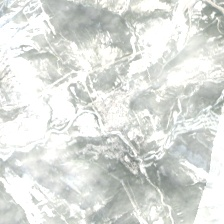

In [ ]:
visualization(point=oval,name='oval_no_mask',mask=False)
Image(filename='oval_no_mask.jpg') 

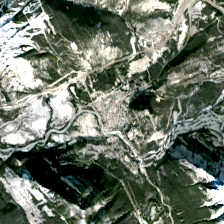

In [ ]:
visualization(point=oval,name='oval_cloud_masking',mask=True)
Image(filename='oval_cloud_masking.jpg')